- <a href="#1">1. Tweepy Notebook</a>
- <a href="#2">2. AWS Comprehend</a>

# <a id='1'> Tweepy Notebook </a>

Notebook will provide an example of how to use the Tweepy package to read tweets, do some simple processing and then load them into pandas.

The first thing you need to do is log into **Twitter** and create an application.

[Twitter Apps](https://apps.twitter.com)

Select the **Create New App** button

and fill out the application information.

You will ultimately need the following pieces of information:

- access_token
- access_token_secret
- consumer_key
- consumer_secret


## <a id='2'>AWS Comprehend Sentiment Analysis</a>

After collecting all of the tweets and example of using the AWS Sentiment analysis API is demonstrated.



In [2]:
import tweepy
import json
import re
import pandas as pd
from config import Config as cfg
import matplotlib.pyplot as plt


In [2]:
access_token = cfg.access_token
access_token_secret = cfg.access_token_secret
consumer_key = cfg.consumer_key
consumer_secret = cfg.consumer_secret

tweet_file_name = 'tweets.txt'
file_mode = 'a'

Create a tweepy OAuthHandler, to be used when we stream the tweets.

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)


In [4]:
class MyStreamListener(tweepy.StreamListener):
    def __init__(self, api=None, file_name='tweets.txt', mode='a', max_tweets=300):
        super(MyStreamListener, self).__init__()
        self.num_tweets = 0
        self.file = open(file_name, mode)
        self.max_tweets = max_tweets

    def on_status(self, status):
        tweet = status._json
        self.file.write( json.dumps(tweet) + '\n' )
        self.num_tweets += 1
        if self.num_tweets < self.max_tweets:
            return True
        else:
            return False
        self.file.close()

    def on_error(self, status):
        print(status)


Select a filter word or words.  Becareful to pick a set of filter words that will give you hits on tweets quickly, else the stream will wait until it has enough tweets before it exits.

In [5]:
filter_words=['trump']

In [6]:
l = MyStreamListener()
stream = tweepy.Stream(auth, l, file_name=tweet_file_name, mode=file_mode, max_tweets=100)

# filters twitter streams to capture data by keywords
stream.filter(track=filter_words)


### Post process the collected tweets

There is clearly a number of things we can do to clean up the tweet text.  I wanted this to be a simple example of some minimal post processing

In [7]:
def word_in_text(word, tweet):
    word = word.lower()
    text = tweet.lower()
    match = re.search(word, text)

    if match:
        return True
    return False


In [8]:
tweets_data = []
tweets_with_words = ['russia', 'SeanHannity', 'Mueller', 'clinton']
with open(tweet_file_name, 'r') as tweets_file:
    for line in tweets_file:
        tweet = json.loads(line)
        user = tweet['user']
        tweet['user_id'] = user['id']
        tweet['screen_name'] = user['screen_name']
        tweet['len'] = len(tweet['text'])
        if tweet['text'].startswith('RT '):
            tweet['retweet'] = 1
            tweet['text'] = tweet['text'].replace('RT ', '', 1)
        else:
            tweet['retweet'] = 0
        for word in tweets_with_words:
            tweet[word] = 1 if word_in_text(word, tweet['text']) else 0
        tweets_data.append(tweet)


In [9]:
columns=['text', 'screen_name', 'len', 'retweet']
columns.extend(tweets_with_words)
df = pd.DataFrame(tweets_data, columns=columns)

print(df.head(20))
print(df.shape)

                                                 text     screen_name  len  \
0             @AlamoOnTheRise https://t.co/ukp07vXGqf        ne1for23   39   
1                     So true https://t.co/Vq9ayIAcAn        jend0315   31   
2   @sumariumcom: Cabello sobre ausencia de Trump ...   REACCI0NARIAA  139   
3   @TrumpTrainMRA4: @facebook \n@DiamondandSilk \...     Crowntiptoe  140   
4   @page88: Thread. Don’t think this overstates m...    JadeJensen29   80   
5   @SpeakerRyan @SenateMajLdr #ProtectMueller #Pr...      Terryg1979   85   
6   @funder: Trump sending troops to the border, i...   IamBrooklyn31  140   
7   @AnnCoulter: Mueller is DYING to get fired.  T...          SPeek1  139   
8   Yup.\nTrain wreck coming.\n#Resist\n#Resign\n#...       titeman50   73   
9   @drscott_atlanta: #FBI raids @realDonaldTrump’...       Jdflygirl  140   
10  @MSNBC: The New York Times reports special cou...     hani_azer11  140   
11  @CoreyLMJones: Mark Zuckerberg said that Faceb...  Mikeypoos

In [10]:
df.to_csv('./data/tweets.csv')

# AWS Comprehend Sentiment Analysis

This section assumes you have an AWS account, and you have created an IAM user and generated the access tokens.

## AWS Comprehend API

To use the comprehend API, and in particular the sentiment analysis api:

- *pip install awscli*
- *aws configure*
- supply your users access key and secret key which you get from the IAM console

See the following documents:
- [Python Boto3 API](https://boto3.readthedocs.io/en/latest/guide/quickstart.html)

- [Amazon Comprehend Documents](https://docs.aws.amazon.com/comprehend/latest/dg/what-is.html)

The above will setup the configuration in the default profile.


In [3]:
tweets_df = pd.read_csv('./data/tweets.csv')

In [4]:
import boto3
import json

In [5]:
comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')

For each of the tweets, call the sentiment API and add to the data frame the resulting sentimment, and the individual probabilities of the different sentiments.

In [6]:
for tweet in tweets_df['text']:
    response = comprehend.detect_sentiment(Text=tweet, LanguageCode='en')
    sentiment = response['Sentiment']
    sentiment_mixed = response['SentimentScore']['Mixed']
    sentiment_negative = response['SentimentScore']['Negative']
    sentiment_neutral = response['SentimentScore']['Neutral']
    sentiment_positive = response['SentimentScore']['Positive']
    tweets_df['sentiment'] = sentiment
    tweets_df['sentiment_mixed'] = sentiment_mixed
    tweets_df['sentiment_negative'] = sentiment_negative
    tweets_df['sentiment_neutral'] = sentiment_neutral
    tweets_df['sentiment_positive'] = sentiment_positive
    
    #print(f"[{sentiment}\n{tweet}\n]")


In [7]:
tweets_df.to_csv('./data/tweets_sentiment.csv')

## Wordcloud

Lets setup a word cloud to show the words in the tweets


In [8]:
from os import path
from wordcloud import WordCloud

tweets_df = pd.read_csv('./data/tweets_sentiment.csv')

In [9]:
# remove urls
regex = re.compile(r"http.?://[^\s]+[\s]?")
tweets_df.text.replace(regex, "", inplace=True)

In [10]:
# remove user name
regex = re.compile(r"@[^\s]+[\s]?")
tweets_df.replace(regex, "", inplace=True)

In [11]:
# html encoded characters
for remove in map(lambda r: re.compile(r), ["&lt;", "&gt;", "&quot;", "&amp;", "w/o", "w/"]):
    tweets_df.replace(remove, "", inplace=True)

In [12]:
# remove Donald, Trump, President, etc to get a better idea of what people are saying
for remove in map(lambda r: re.compile(r), ["Trump", "President", "Donald", "amp", "don", "trump", "will", "say", "said", "new", "day"]):
    tweets_df.replace(remove, "", inplace=True)

(-0.5, 399.5, 199.5, -0.5)

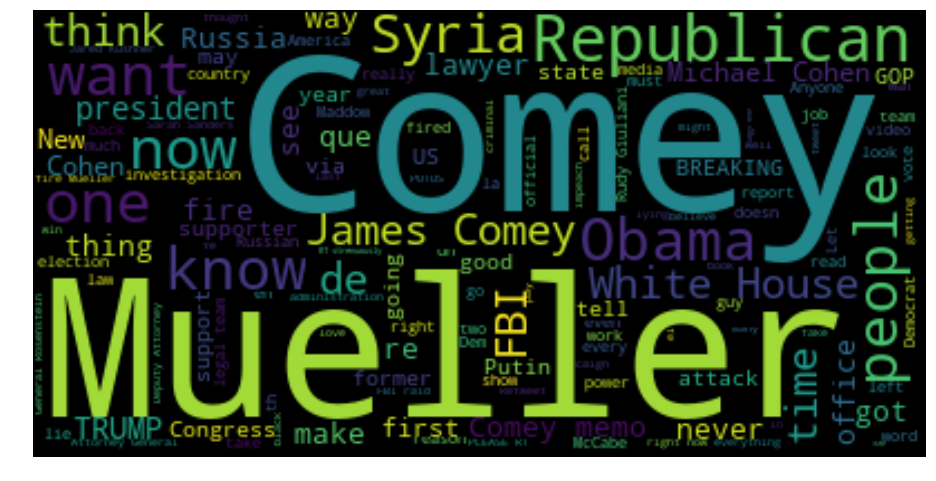

In [13]:

# Generate a word cloud image
text = ' '.join(tweets_df['text'])
wordcloud = WordCloud().generate(text) #WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


(-0.5, 399.5, 199.5, -0.5)

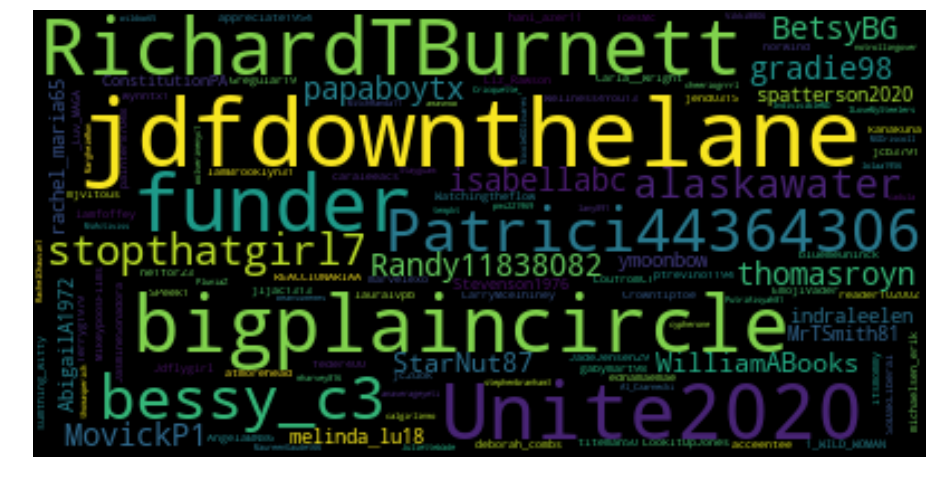

In [14]:
# USERNAME

# Generate a word cloud image
text = ' '.join(tweets_df['screen_name'])
wordcloud = WordCloud().generate(text) #WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


(-0.5, 399.5, 199.5, -0.5)

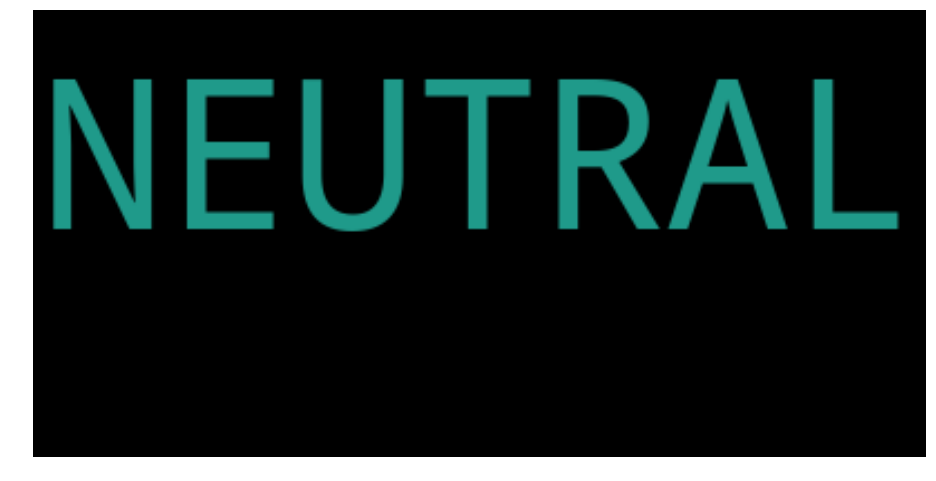

In [15]:
#Sentiment

# Generate a word cloud image
text = ' '.join(tweets_df['sentiment'])
wordcloud = WordCloud().generate(text) #WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
